# Análisis de Sentimiento - Parte 2 (PCA)


Primero, bajemos los datos

In [ ]:
!wget https://github.com/finiteautomata/imdb-dataset/raw/master/imdb_dataset.csv.zip
!unzip imdb_dataset.csv.zip

--2020-06-06 17:32:19--  https://github.com/finiteautomata/imdb-dataset/raw/master/imdb_dataset.csv.zip
Resolving github.com (github.com)... 18.228.67.229
Connecting to github.com (github.com)|18.228.67.229|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/finiteautomata/imdb-dataset/master/imdb_dataset.csv.zip [following]
--2020-06-06 17:32:20--  https://raw.githubusercontent.com/finiteautomata/imdb-dataset/master/imdb_dataset.csv.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.220.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.220.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26962657 (26M) [application/zip]
Saving to: ‘imdb_dataset.csv.zip’

imdb_dataset.csv.zi  68%[============>       ]  17,74M   204KB/s    eta 33s    

## Método de la Potencia

In [1]:
import numpy as np

def power_iteration(A, niter=1000, eps=1e-6):
    b = np.random.rand(A.shape[1])
    b = b / np.linalg.norm(b)

    for i in range(niter):
        old = b
        b = A @ b
        b = b / np.linalg.norm(b)

        # <a, b> = |a| |b| cos(angle)
        # -1 < cos(angle) < 1
        cos_angle = np.dot(b, old)
        if (1 - eps) < cos_angle <= 1:
            print(f"Paré en la iteración {i+1}")
            break

    eigenvalue = np.dot(b, A @ b)
    return eigenvalue, b


In [2]:
D = np.diag(range(100, 0, -1))

v = np.ones((D.shape[0], 1))
v = v / np.linalg.norm(v)

# Matriz de Householder
B = np.eye(D.shape[0]) - 2 * (v @ v.T)

# Matriz ya diagonalizada
M = D



In [3]:
%%time
l, v = power_iteration(M, niter=1000, eps=1e-7)



Paré en la iteración 306
CPU times: user 94.5 ms, sys: 84.2 ms, total: 179 ms
Wall time: 77.7 ms


In [ ]:
l, v

In [4]:


def eigen(A, num=2, **kwargs):
    A = A.copy()
    eigenvalues = []
    eigenvectors = np.zeros((A.shape[0], num))
    for i in range(num):
        print(f"Autovalor {i+1}")
        l, v = power_iteration(A, **kwargs)
        eigenvalues.append(l)
        eigenvectors[:, i] = v
        
        A = A - l * np.outer(v, v)
        
    return np.array(eigenvalues), eigenvectors


In [5]:
A = np.array([
  [7, 2, 3],
  [0, 2, 0],
  [-6, -2, -2]
])

w, V = eigen(A, num=3, niter=20000, eps=1e-24)

Autovalor 1
Autovalor 2
Autovalor 3


In [6]:
for i in range(len(A)):
    print(np.allclose(A @ V[:, i], w[i] * V[:,i]))
    print(A @ V[:, i])
    print(w[i] * V[:,i])
        

True
[ 2.82842712  0.         -2.82842712]
[ 2.82842712  0.         -2.82842712]
False
[ 3.46410162  1.15470054 -3.46410162]
[ 1.15470054  1.15470054 -1.15470054]
False
[-2.0302589  -1.87408514  2.18643267]
[-0.15617376 -0.93704257  0.31234752]


Veamos algunos ejemplos...

In [7]:
D = np.diag(range(1000, 0, -1))

v = np.ones((D.shape[0], 1))
v = v / np.linalg.norm(v)

# Matriz de Householder
B = np.eye(D.shape[0]) - 2 * (v @ v.T)

# Matriz ya diagonalizada
M = B.T @ D @ B

eigen(M, 10, niter=1000, eps=1e-6)

Autovalor 1
Paré en la iteración 295
Autovalor 2
Paré en la iteración 433
Autovalor 3
Paré en la iteración 400
Autovalor 4
Paré en la iteración 420
Autovalor 5
Paré en la iteración 395
Autovalor 6
Paré en la iteración 390
Autovalor 7
Paré en la iteración 431
Autovalor 8
Paré en la iteración 320
Autovalor 9
Paré en la iteración 315
Autovalor 10
Paré en la iteración 455


(array([999.04188605, 998.52834512, 997.71030171, 995.35253261,
        996.49821932, 996.13061114, 994.04389994, 992.09633924,
        989.87970101, 991.9009454 ]),
 array([[-0.72338918,  0.6579003 ,  0.05198151, ...,  0.02370883,
          0.01399858, -0.05170293],
        [-0.43130115, -0.30247453, -0.54866535, ..., -0.03176792,
          0.0198307 ,  0.13713332],
        [-0.4305532 , -0.56444129,  0.60443174, ...,  0.0257758 ,
          0.0578574 ,  0.00866307],
        ...,
        [ 0.00453309,  0.00240904,  0.00177325, ...,  0.00275875,
          0.00292448,  0.00078931],
        [ 0.00453309,  0.00240904,  0.00177325, ...,  0.00275875,
          0.00292448,  0.00078931],
        [ 0.00453309,  0.00240904,  0.00177325, ...,  0.00275875,
          0.00292448,  0.00078931]]))

## Volvamos a Análisis de Sentimiento

In [8]:
import pandas as pd 
import sklearn

df = pd.read_csv("IMDB Dataset.csv")
df = df.sample(frac=1, random_state=2020)

df_train = df[:10000]
df_test = df[10000:13000]

text_train, text_test = df_train["review"], df_test["review"]
label_train, label_test = df_train["sentiment"], df_test["sentiment"]

print("Class balance : {} pos {} neg".format(
    (label_train == 'positive').sum() / label_train.shape[0], 
    (label_train == 'negative').sum() / label_train.shape[0]
))
print("Cantidad de documentos: {}".format(df.shape[0]))

Class balance : 0.5007 pos 0.4993 neg
Cantidad de documentos: 50000


Veamos qué forma tienen los datos

In [9]:
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer(min_df=4, max_df=0.80, max_features=6000, binary=True)

vect.fit(text_train)

X_train = vect.transform(text_train)
X_test = vect.transform(text_test)

y_train = label_train# == 'positive' # Convertimos a vectores booleanos
y_test = label_test# == "positive"

## PCA

Vamos a ver una técnica para reducir la dimensionalidad y aún así mantener la mayor cantidad de información posible.

Recordemos que, dada X su matriz de covarianza $M_X$ es

$$ M_X = \frac{X^T X}{n-1} $$

En primer lugar, calculemos la matriz de covarianza de $X_{train}$

In [10]:
import numpy as np

# Esto es porque me lo convierte a np.matrix si no
X = np.array(X_train - X_train.mean(axis=0))

cov_matrix = X.T @ X / (X.shape[0]-1) 

In [11]:
%%time
w, V = eigen(cov_matrix, num=30, niter=1000, eps=1e-6)

Autovalor 1
Paré en la iteración 5
Autovalor 2
Paré en la iteración 9
Autovalor 3
Paré en la iteración 91
Autovalor 4
Paré en la iteración 61
Autovalor 5
Paré en la iteración 46
Autovalor 6
Paré en la iteración 72
Autovalor 7
Paré en la iteración 76
Autovalor 8
Paré en la iteración 61
Autovalor 9
Paré en la iteración 189
Autovalor 10
Paré en la iteración 112
Autovalor 11
Paré en la iteración 51
Autovalor 12
Paré en la iteración 105
Autovalor 13
Paré en la iteración 97
Autovalor 14
Paré en la iteración 271
Autovalor 15
Paré en la iteración 212
Autovalor 16
Paré en la iteración 114
Autovalor 17
Paré en la iteración 578
Autovalor 18
Paré en la iteración 107
Autovalor 19
Paré en la iteración 176
Autovalor 20
Paré en la iteración 245
Autovalor 21
Paré en la iteración 110
Autovalor 22
Paré en la iteración 146
Autovalor 23
Paré en la iteración 225
Autovalor 24
Paré en la iteración 242
Autovalor 25
Paré en la iteración 225
Autovalor 26
Paré en la iteración 134
Autovalor 27
Paré en la iteración

A ver los autovalores...

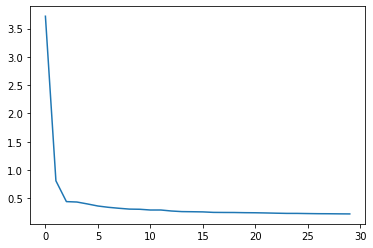

In [12]:
import matplotlib.pyplot as plt

plt.plot(w)

## Recordando cambios de base y otros yuyos

Sup $M_X$ es la matriz de la covarianza, 

$$ M_X = \frac{X^T X}{n-1} $$

Si $B = \{v_1, \ldots , v_n\}$ es la base ortogonal de autovectores de $M_X$ entonces la matriz cambio de base de $B$ a la base canónica ($E$) se escribe como la matriz cuyas columnas son los respectivos vectores

$$C_{B, E} = V = \begin{bmatrix}
        &     & \ldots &     \\
    v_1 & v_2 & \ldots & v_n \\
        &     & \ldots &     \\
\end{bmatrix}
$$


La matriz inversa de ésta es la cambio de base de $E$ a $B$. Es decir $C_{E, B} = C_{B, E}^{-1}$. Como nuestra base es ortogonal, tenemos

$$ C_{E, B} = C_{B, E}^T = V^T = \begin{bmatrix}
& & v_1   & &\\
& & v_2   & &\\
& &\vdots & & \\
& & v_n   & & \\
\end{bmatrix}
$$

Es decir, la matriz que consiste de apilar los vectores fila de la base $B$.


### Cambiando de base nuestras instancias de entrenamiento

Nuestras matrices $X \in R^{n \times m}$ con $n$ igual a la cantidad de instancias de entrenamiento, y $m$ la cantidad de variables

Tenemos entonces

$$ X = \begin{bmatrix}
& & x^{(1)}   & &\\
& & x^{(2)}   & &\\
& &\vdots & & \\
& & v_n   & & \\
\end{bmatrix}
$$

Si $x$ es una instancia de entrenamiento a la cual queremos cambiar de base, queremos hacer

$$\overline x = V^T x$$

Luego, si queremos cambiar de base cada instancia, hacemos...

$$ V^T X^T = V^T \begin{bmatrix}
        & &    & &\\
x^{(1)}& x^{(2)} &\ldots & x ^{(n-1)} & x ^{(n)} \\
& & & & \\
\end{bmatrix} = \begin{bmatrix}
        & &    & &\\
V^T x^{(1)}& V^T x^{(2)} &\ldots & V^T x ^{(n-1)} & V^T x ^{(n)} \\
& & & & \\
\end{bmatrix} = \begin{bmatrix}
        & &    & &\\
\overline{x^{(1)}}& \overline{x^{(2)}} &\ldots & \overline{x^{(n-1)}} & \overline{x^{(n)}} \\
& & & & \\
\end{bmatrix}
$$

Ahora, lo que necesitamos es que cada instancia esté en una fila, así que trasponemos

$$
\overline{X} = (V^T X^T)^T = X V
$$

## Ejercicio:

1. Implementar el cambio de base usando su implementación del método de la potencia
2. Experimentar con distintos $\alpha$. ¿Cómo afecta la accuracy de nuestro algoritmo? ¿Es más rápido (en tiempo)?

In [15]:
X_train

<10000x6000 sparse matrix of type '<class 'numpy.int64'>'
	with 1123556 stored elements in Compressed Sparse Row format>

In [18]:
import metnum as mt

N_NEIGHBORS = 100
#components for PCA
N_COMPONENTS=20
#number of iterations to find eigenvalues and eigenvectors in power iteration
N_ITERATIONS=100
#epsilon for power iteration
EPSILON=1e-10

pca = mt.PCA(N_COMPONENTS, N_ITERATIONS, EPSILON)
pca.fit(pd.lreshape (X_train))

X_pca_train, X_pca_test = pca.transform(X_train), pca.transform(X_val)

#X_pca_train = X_train @ V[:, :20]
#X_pca_test = X_test @ V[:, :25]

X_pca_train.shape

ValueError: PandasArray must be 1-dimensional.

Entrenar ahora el clasificador usando estas nuevas instancias[]

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(n_neighbors=50)
clf.fit(X_pca_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=50, p=2,
                     weights='uniform')

In [ ]:
%%time
from sklearn.metrics import accuracy_score
y_pred = clf.predict(X_pca_test)

acc = accuracy_score(y_test, y_pred)
print("Accuracy: {}".format(acc))

Accuracy: 0.781
CPU times: user 1.7 s, sys: 1.24 ms, total: 1.7 s
Wall time: 1.71 s
